# LDAS Cloud Use Case

## Demonstrate differences in soil moisture between LDAS model output and CYGNSS satellite retrievals in the Earthdata Cloud

### Audience
Soil moisture researchers who want to see differences between model- and satellite-based products

### Goal
Compare soil moisture from LDAS (NLDAS, GLDAS models) and CYGNSS (satellite retrieval) in different regions of the world (Southern Great Plains, East Africa) using in-region Earthdata Cloud access.

### Assumptions
- A variable of interest is identified
- Data collections of interest are identified
- User has procured access to computing resources in the AWS us-west-2 region

### Preconditions
- User has access to computing resources in the AWS us-west-2 region
- LDAS and CYGNSS data collections are available in the Earthdata Cloud
- Identify area(s) of interest for area-averaging
    - Southern Great Plains: 100-95 W and 32-37 N
    - East Africa: 43-48 E and 5-10 N  

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

## Prerequisites

This notebook was written using Python 3.8, and requires these libraries and files:
- xarray
- cartopy
- matplotlib
- S3FS
  - S3FS documentation: (https://s3fs.readthedocs.io/en/latest/install.html)
- netrc file with valid Earthdata Login credentials
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)

## Import Libraries

In [1]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
from scipy.interpolate import griddata
import numpy as np

## Credentials

Two credentials are required for in-cloud direct S3 access of Earthdata:
 - Earthdata Login username and password
 - Temporary S3 access credential for NASA DAAC archives

The S3 credential is generated by a lambda function that uses the Earthdata Login credentials provided in your <code>.netrc</code> file to create an access key ID, secret access key, and session token for accessing GES DISC S3 buckets. **This token will only last for one hour**, and if time expires, the kernel will need to be reset and the following cell run again. This notebook also accesses data archived by PO.DAAC. You will also need to generate S3 credentials for PO.DAAC.

### STOP: Do you have your Earthdata Login credentials stored in the root directory of this compute system?

If no, run the below cell to store your Earthdata username and password in a <code>.netrc</code> file.
    
If yes, proceed to the next cell.
    


In [2]:
## You may skip this cell if you have already stored your Earthdata Login credentials

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

In [3]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
podaac_s3 = "https://archive.podaac.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials
def begin_s3_direct_access(url: str=gesdisc_s3):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

## Find Data

Use the CMR API to search for the data collections of interest in the desired time range and create a list of S3 URLs that will be accessed. 

### Date Range

- 01 June 2018 - 10 October 2018

### Region

- Southern Great Plains (100-95 W and 32-37 N)

### Data Collections and Variables
| Longname    | Shortname | Variable | CMR Concept ID | Time Resolution | Spatial Resolution |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| [NLDAS Noah Land Surface Model L4 Hourly 0.125 x 0.125 degree V2.0](https://disc.gsfc.nasa.gov/datasets/NLDAS_NOAH0125_H_2.0/summary?keywords=NLDAS_NOAH0125_H) | NLDAS_NOAH0125_H | SoilM_0_10cm | C2069246977-GES_DISC | Hourly | 0.125 deg |
| [GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.25 degree V2.1](https://disc.gsfc.nasa.gov/datasets/GLDAS_NOAH025_3H_2.1/summary?keywords=GLDAS_NOAH025_3H_2.1) | GLDAS_NOAH025_3H | SoilMoi0_10cm_inst | C1342986035-GES_DISC | 3-Hourly | 0.25 deg | 
| [UCAR-CU CYGNSS Level 3 Soil Moisture Version 1.0](https://podaac.jpl.nasa.gov/dataset/CYGNSS_L3_SOIL_MOISTURE_V1.0) | CYGNSS_L3_SOIL_MOISTURE_V1.0 | SM_daily | C2205122332-POCLOUD | Daily | ~0.37 deg lon. by ~0.30 deg lat. |



In [4]:
# Create a function for CMR catalog requests
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

In [5]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'
start_time = '2018-06-01T00:00:00Z'
end_time = '2018-07-01T00:00:00Z'

### NLDAS hourly granules 

Use the table above to fill in the concept ID for the NLDAS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [6]:
nldas_concept_id = 'C2069246977-GES_DISC'
page_size = 24*30+1
response = cmr_request({
                        'concept_id': nldas_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
nldas_granules = response.json()['feed']['entry']

nldas_s3_urls = []
for granule in nldas_granules:
    nldas_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

### GLDAS 3-hourly granules 

Use the table above to fill in the concept ID for the GLDAS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [7]:
gldas_concept_id = 'C1342986035-GES_DISC'
page_size = 8*30+1
response = cmr_request({
                        'concept_id': gldas_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
gldas_granules = response.json()['feed']['entry']

gldas_s3_urls = []
for granule in gldas_granules:
    gldas_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

### CYGNSS daily granules 

Use the table above to fill in the concept ID for the CYGNSS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [8]:
cygnss_concept_id = 'C2205122332-POCLOUD'
page_size = 31
response = cmr_request({
                        'concept_id': cygnss_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
cygnss_granules = response.json()['feed']['entry']

cygnss_s3_urls = []
for granule in cygnss_granules:
    cygnss_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://") and item["href"].endswith(".nc")), None)) 

## Access Data

### Begin S3FS sessions

Begin your S3FS session that you set up earlier in the "Credentials" section.

Remember, these S3FS sessions are specific to the DAAC-owned S3 buckets, so we will create a session for each DAAC we are accessing data from.

In [9]:
fs_gesdisc = begin_s3_direct_access(gesdisc_s3)
fs_podaac = begin_s3_direct_access(podaac_s3)

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs_gesdisc), type(fs_podaac)

(s3fs.core.S3FileSystem, s3fs.core.S3FileSystem)

### Open granules using xarray

We will use the xarray Python library to read and open the files we found using the CMR API and put into lists. 

In [10]:
%%time
nldas_ds = xr.open_mfdataset(
    paths=[fs_gesdisc.open(f) for f in nldas_s3_urls[0:24]],
    combine='by_coords',
    decode_cf=True,
)

CPU times: user 16.1 s, sys: 1.93 s, total: 18.1 s
Wall time: 44.4 s


In [13]:
%%time
gldas_ds = xr.open_mfdataset(
    paths=[fs_gesdisc.open(f) for f in gldas_s3_urls[0:8]],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    parallel=False,
)

CPU times: user 5.96 s, sys: 49.7 ms, total: 6.01 s
Wall time: 7.12 s


In [11]:
%%time
cygnss_ds = xr.open_mfdataset(
    paths=[fs_podaac.open(f) for f in cygnss_s3_urls[0:1]],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    parallel=False,
)

CPU times: user 420 ms, sys: 57.3 ms, total: 477 ms
Wall time: 1.66 s


## Process Data

- Match temporal resolution
- Subset with the bounding box
- Subset by variable
- Re-grid to same spatial resolution
- Remove the data gaps
- Ensure same units


**(4/16/23)ALEXIS'NOTE: Don't do any processing (spatial/variable subset, units) except for temporal resolution until we interpolate/re-grid**

- Match temporal resolution
- Subset NLDAS and GLDAS spatially before regridding (save computational power)
- Re-grid to same spatial resolution
- Subset by variable
- Subset with the bounding box
- Remove the data gaps
- Ensure same units

### Match temporal resolution
Resample NLDAS and GLDAS to daily time resolution to match CYGNSS

In [14]:
nldas_ds_daily = nldas_ds.resample(time="1D").mean()
gldas_ds_daily = gldas_ds.resample(time="1D").mean()

In [16]:
#nldas_ds_daily
#gldas_ds_daily

### Subset spatially with the bounding box: NLDAS and GLDAS

Why? Save computational power later when interpolating

Southern Great Plains: 100-95 W and 32-37 N

In [15]:
min_lon = -100
min_lat = 32
max_lon = -95
max_lat = 37


nldas_sgp = nldas_ds_daily.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
gldas_sgp = gldas_ds_daily.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

In [17]:
nldas_sgp.SoilM_0_10cm

<xarray.DataArray 'SoilM_0_10cm' (time: 1, lat: 40, lon: 40)>
dask.array<getitem, shape=(1, 40, 40), dtype=float32, chunksize=(1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -99.94 -99.81 -99.69 -99.56 ... -95.31 -95.19 -95.06
  * lat      (lat) float32 32.06 32.19 32.31 32.44 ... 36.56 36.69 36.81 36.94
  * time     (time) datetime64[ns] 2018-06-01
Attributes:
    units:          kg m-2
    standard_name:  Average layer soil moisture
    long_name:      Soil moisture content (0-10cm)
    cell_methods:   time: point
    vmin:           3.3999999
    vmax:           43.399998

### Re-grid to same spatial resolution

Interpolate NLDAS/GLDAS to CYGNSS grid

In [22]:
%%time
# NLDAS --> CYGNSS interpolation
nx, ny = np.meshgrid(nldas_sgp.lon.values, nldas_sgp.lat.values)
nldas_pts = np.stack([nx.ravel(), ny.ravel()], axis=1)

cx, cy = cygnss_ds.longitude.values, cygnss_ds.latitude.values
cygnss_pts = np.stack([cx.ravel(), cy.ravel()], axis=1)

nldas_sm_interp = griddata(nldas_pts, nldas_sgp.SoilM_0_10cm[0,:,:].values.flatten(), cygnss_pts, method='linear')

nldas_sm_interp = nldas_sm_interp.reshape(1, 252, 802)
nldas_sm_interp

CPU times: user 215 ms, sys: 23.8 ms, total: 239 ms
Wall time: 187 ms


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])

In [23]:
%%time
# GLDAS --> CYGNSS interpolation
nx, ny = np.meshgrid(gldas_sgp.lon.values, gldas_sgp.lat.values)
gldas_pts = np.stack([nx.ravel(), ny.ravel()], axis=1)

cx, cy = cygnss_ds.longitude.values, cygnss_ds.latitude.values
cygnss_pts = np.stack([cx.ravel(), cy.ravel()], axis=1)

gldas_sm_interp = griddata(gldas_pts, gldas_sgp.SoilMoi0_10cm_inst[0,:,:].values.flatten(), cygnss_pts, method='linear')

gldas_sm_interp = gldas_sm_interp.reshape(1, 252, 802)
#gldas_sm_interp

CPU times: user 298 ms, sys: 44.7 ms, total: 343 ms
Wall time: 275 ms


### Add interpolated variables to CYGNSS data array and convert units


Divide NLDAS and GLDAS by 100.0 to convert from [kg m-2] to [m^3 m-3].


CYGNSS is in [cm^3 cm-3], which is identical to [m^3 m-3].

In [24]:
cygnss_ds = cygnss_ds.assign(NLDAS_SoilM_0_10cm=(["time", "lat", "lon"], nldas_sm_interp/100))
cygnss_ds.NLDAS_SoilM_0_10cm

<xarray.DataArray 'NLDAS_SoilM_0_10cm' (time: 1, lat: 252, lon: 802)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-06-01T12:00:00
Dimensions without coordinates: lat, lon

In [25]:
cygnss_ds = cygnss_ds.assign(GLDAS_SoilMoi0_10cm_inst=(["time", "lat", "lon"], gldas_sm_interp/100))
cygnss_ds.GLDAS_SoilMoi0_10cm_inst

<xarray.DataArray 'GLDAS_SoilMoi0_10cm_inst' (time: 1, lat: 252, lon: 802)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-06-01T12:00:00
Dimensions without coordinates: lat, lon

### Subset with bounding box: Handle CYGNSS differently

- Set coordinates to "latitude" and "longitude" (they're listed as 2D variables in the file)
- Clip to bounding box

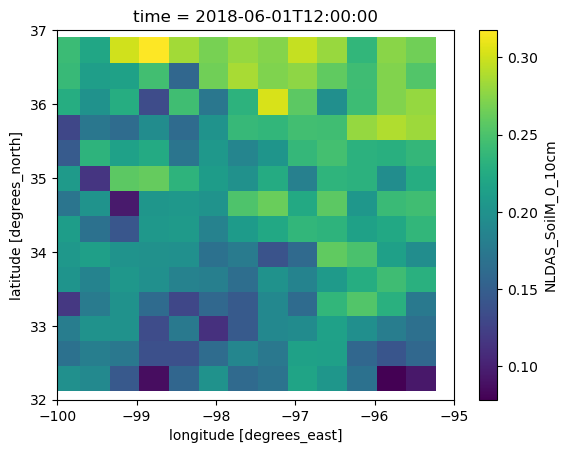

In [26]:
# Reassign coordinates using the latitude and longitude variables
cygnss_interp_ra = cygnss_ds.set_coords(("latitude", "longitude"))

# Clip the soil moisture variable to the specified bounding box for Southern Great Plains
cygnss_interp_sgp = cygnss_interp_ra.where((cygnss_interp_ra.latitude > min_lat) & (cygnss_interp_ra.latitude < max_lat) & (cygnss_interp_ra.longitude > min_lon) & (cygnss_interp_ra.longitude < max_lon))

# Plot the regridded NLDAS variable on the CYGNSS grid
cygnss_interp_sgp.NLDAS_SoilM_0_10cm[0,:,:].plot(x="longitude", y="latitude",xlim=(min_lon,max_lon),ylim=(min_lat,max_lat))

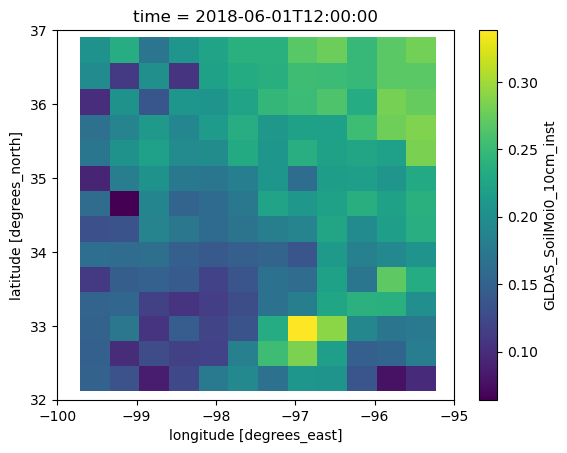

In [27]:
# Plot the regridded GLDAS variable on the CYGNSS grid
cygnss_interp_sgp.GLDAS_SoilMoi0_10cm_inst[0,:,:].plot(x="longitude", y="latitude",xlim=(min_lon,max_lon),ylim=(min_lat,max_lat))

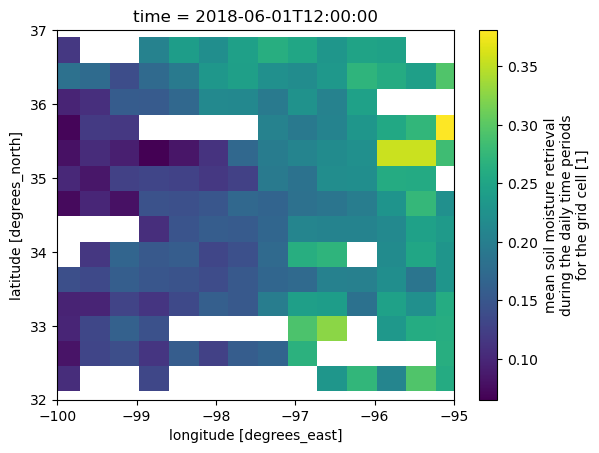

In [28]:
# Check on CYGNSS soil moisture
cygnss_interp_sgp.SM_daily[0,:,:].plot(x="longitude", y="latitude",xlim=(min_lon,max_lon),ylim=(min_lat,max_lat))

### Subset by variable: soil moisture

Variable names
- NLDAS: NLDAS_SoilM_0_10cm
- GLDAS: GLDAS_SoilMoi0_10cm_inst
- CYGNSS: SM_daily

In [33]:
#nldas_sm = nldas_sgp.SoilM_0_10cm
#gldas_sm = gldas_sgp.SoilMoi0_10cm_inst
#cygnss_sm = cygnss_sgp.SM_daily

cygnss_interp_sgp.NLDAS_SoilM_0_10cm
cygnss_interp_sgp.GLDAS_SoilMoi0_10cm_inst
cygnss_interp_sgp.SM_daily

## Apply CYGNSS masking to interpolated NLDAS/GLDAS

## Derive area-averages

In [43]:
#cygnss_interp_sgp.SM_daily[0,:,:].plot(x="longitude", y="latitude")#,xlim=(min_lon,max_lon),ylim=(min_lat,max_lat))

#cygnss_areaavg = cygnss_interp_sgp.SM_daily[0,:,:].values.nanmean()
#print(cygnss_areaavg)
print('CYGNSS Area-Averaged Soil Moisture at SGP:', np.nanmean(cygnss_interp_sgp.SM_daily[0,:,:]), 'm^3 m-3')
print('NLDAS Area-Averaged Soil Moisture at SGP:', np.nanmean(cygnss_interp_sgp.NLDAS_SoilM_0_10cm[0,:,:]), 'm^3 m-3')
print('CYGNSS Area-Averaged Soil Moisture at SGP:', np.nanmean(cygnss_interp_sgp.GLDAS_SoilMoi0_10cm_inst[0,:,:]), 'm^3 m-3')

CYGNSS Area-Averaged Soil Moisture at SGP: 0.18760766 m^3 m-3
NLDAS Area-Averaged Soil Moisture at SGP: 0.20680394523447007 m^3 m-3
CYGNSS Area-Averaged Soil Moisture at SGP: 0.1910581588971824 m^3 m-3


## Plot time series